In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

The following dataset, Google Play Store Apps, is from Kaggle. It was web scraped and was last updated February 3rd, 2019.

There are just over 10,000 entries, each of which is an application available on Google Play Store.

We choose the average user rating as our target.

In [2]:
df = pd.read_csv('googleplaystore.csv')
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.900,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.500,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,nan,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
# With few nulls, we simply drop them.
df = df.dropna()

The category of each app is the primary genre. The genres column has comma seperated values, so that an app can have multiple genres. With little difference between these two, we will only use the category column and not genres. The current version and android version columns are not that usable with double-decimaled "numbers" and inconsistent text appearing, so we also drop these two columns.

In [5]:
df = df.drop(columns = ['Genres', 'Current Ver', 'Android Ver'], axis=1)

In [6]:
#We convert all data to numeric, and get dummies for categorical variables.
#To make this a classification instead of regression problem, we make the target an integer so that there a 5 categories.

df['Reviews'] = pd.to_numeric(df['Reviews'])

df['Size'] = df['Size'].apply(lambda x:  pd.to_numeric(x.strip('M'))*1000000 if 'M' in x else(
                                        pd.to_numeric(x.strip('k'))*1000 if 'k' in x else x))
df['Size'] = df['Size'].replace(to_replace='Varies with device', value=np.nan, regex=True)

df['Installs'] = df['Installs'].str.strip(to_strip='+')
df['Installs'] = df['Installs'].replace(to_replace=',', value='',regex=True)
df['Installs'] = pd.to_numeric(df['Installs'])

df['Price'] = df['Price'].str.strip(to_strip='$')
df['Price'] = pd.to_numeric(df['Price'])

df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df['Last Updated'] = (df['Last Updated'] - df['Last Updated'].min()).dt.days

df['Rating'] = df['Rating'].round()
df['Rating'] = df['Rating'].astype(dtype='int')

df = pd.get_dummies(data=df, columns=['Category', 'Type', 'Content Rating'], drop_first=True)

df.dropna(inplace=True)

In [8]:
df['Size'] = df['Size'].replace(to_replace='Varies with device', value=np.nan, regex=True)
df.dropna(inplace=True)
df

,App,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,4,159,19000000.000,10000,0.000,2788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Coloring book moana,4,967,14000000.000,500000,0.000,2796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",5,87510,8700000.000,5000000,0.000,2994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Sketch - Draw & Paint,4,215644,25000000.000,50000000,0.000,2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Pixel Draw - Number Art Coloring Book,4,967,2800000.000,100000,0.000,2952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833,Chemin (fr),5,44,619000.000,1000,0.000,1402,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10834,FR Calculator,4,7,2600000.000,500,0.000,2585,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10836,Sya9a Maroc - FR,4,38,53000000.000,5000,0.000,2622,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10837,Fr. Mike Schmitz Audio Teachings,5,4,3600000.000,100,0.000,2968,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


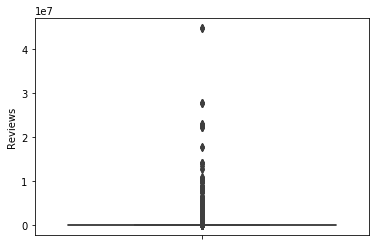

In [9]:
sns.boxplot(y=df['Reviews'])

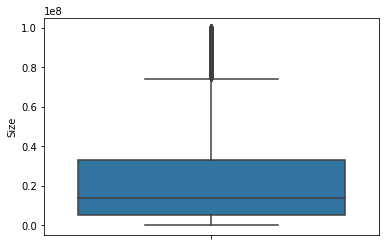

In [10]:
sns.boxplot(y=df['Size'])

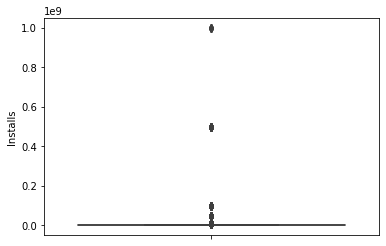

In [11]:
sns.boxplot(y=df['Installs'])

In [12]:
#For the final pre-processing step, We log transform the Reviews and Intalls columns.

df['Reviews'] = np.log(df['Reviews'])
df['Installs'] = np.log(df['Installs'])

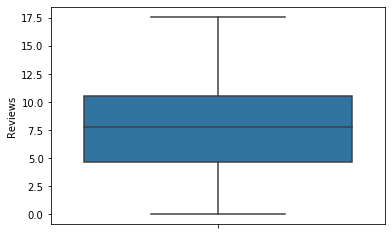

In [13]:
sns.boxplot(y=df['Reviews'])

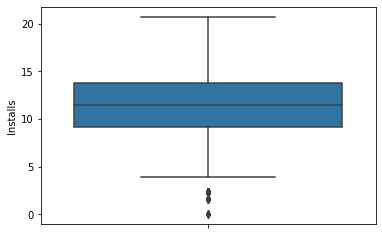

In [14]:
sns.boxplot(y=df['Installs'])

In [16]:
df.corr()

,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
Rating,1.000,0.074,0.036,-0.012,-0.008,0.107,0.004,0.016,0.048,-0.015,-0.003,-0.028,-0.045,0.045,-0.012,0.040,0.019,-0.008,-0.007,0.024,0.029,-0.009,0.004,-0.004,-0.031,0.013,-0.006,0.036,0.041,-0.018,-0.006,-0.003,0.020,0.008,-0.076,-0.040,-0.028,0.002,0.050,-0.006,0.019,-0.027,0.013,-0.002
Reviews,0.074,1.000,0.375,0.954,-0.040,0.223,-0.034,-0.033,-0.040,-0.096,-0.014,0.020,-0.030,0.059,0.085,-0.043,-0.046,-0.052,0.016,0.277,0.009,0.012,-0.035,-0.074,-0.019,-0.161,-0.017,-0.024,-0.035,0.069,-0.010,0.056,0.023,0.035,-0.065,-0.007,0.014,0.026,-0.173,-0.192,0.135,0.028,0.139,-0.002
Size,0.036,0.375,1.000,0.334,-0.026,0.234,-0.006,-0.022,-0.050,-0.062,-0.033,-0.075,-0.030,-0.011,-0.005,-0.026,0.158,-0.035,0.005,0.362,0.009,-0.020,-0.039,-0.063,-0.026,-0.032,-0.063,-0.004,-0.093,-0.041,-0.076,-0.038,-0.025,0.027,-0.187,0.014,-0.036,-0.033,-0.028,-0.218,0.157,0.039,0.153,-0.008
Installs,-0.012,0.954,0.334,1.000,-0.059,0.226,-0.022,-0.018,-0.035,-0.091,-0.014,0.019,-0.030,0.061,0.086,-0.041,-0.051,-0.058,0.025,0.233,0.006,0.024,-0.021,-0.065,-0.018,-0.162,-0.017,-0.008,-0.043,0.076,-0.007,0.063,0.011,0.023,-0.044,0.008,0.025,0.026,-0.268,-0.156,0.113,0.023,0.111,-0.003
Price,-0.008,-0.040,-0.026,-0.059,1.000,0.001,-0.006,-0.004,-0.008,-0.009,-0.005,-0.009,-0.009,-0.007,-0.007,-0.005,0.008,0.087,-0.006,-0.018,-0.010,-0.006,-0.006,0.065,-0.006,0.023,-0.009,-0.004,-0.008,-0.008,-0.009,-0.010,-0.010,-0.008,-0.014,-0.008,-0.008,-0.003,0.228,0.017,-0.008,-0.011,-0.008,-0.001
Last Updated,0.107,0.223,0.234,0.226,0.001,1.000,0.035,0.028,-0.027,0.004,0.030,-0.020,0.077,0.011,0.050,0.023,-0.060,0.051,0.050,-0.016,0.039,0.004,-0.038,-0.014,0.019,-0.010,0.042,0.033,-0.093,-0.000,-0.025,0.065,0.025,0.038,-0.070,0.035,-0.019,-0.005,-0.174,-0.065,0.016,0.059,0.034,-0.057
Category_AUTO_AND_VEHICLES,0.004,-0.034,-0.006,-0.022,-0.006,0.035,1.000,-0.006,-0.013,-0.016,-0.007,-0.015,-0.014,-0.011,-0.010,-0.006,-0.047,-0.017,-0.010,-0.034,-0.016,-0.008,-0.008,-0.018,-0.010,-0.019,-0.014,-0.007,-0.018,-0.016,-0.016,-0.014,-0.014,-0.016,-0.027,-0.013,-0.011,-0.007,-0.026,0.038,-0.012,-0.020,-0.028,-0.001
Category_BEAUTY,0.016,-0.033,-0.022,-0.018,-0.004,0.028,-0.006,1.000,-0.010,-0.013,-0.006,-0.012,-0.011,-0.008,-0.008,-0.005,-0.036,-0.013,-0.007,-0.026,-0.012,-0.006,-0.006,-0.013,-0.008,-0.015,-0.010,-0.005,-0.013,-0.012,-0.012,-0.011,-0.011,-0.013,-0.021,-0.010,-0.009,-0.006,-0.020,0.021,-0.014,-0.007,-0.013,-0.001
Category_BOOKS_AND_REFERENCE,0.048,-0.040,-0.050,-0.035,-0.008,-0.027,-0.013,-0.010,1.000,-0.025,-0.011,-0.023,-0.021,-0.017,-0.015,-0.010,-0.071,-0.026,-0.014,-0.052,-0.024,-0.012,-0.012,-0.027,-0.015,-0.029,-0.021,-0.010,-0.027,-0.024,-0.024,-0.021,-0.021,-0.025,-0.041,-0.020,-0.017,-0.011,-0.014,0.036,-0.004,-0.022,-0.028,-0.002
Category_BUSINESS,-0.015,-0.096,-0.062,-0.091,-0.009,0.004,-0.016,-0.013,-0.025,1.000,-0.014,-0.030,-0.027,-0.022,-0.020,-0.013,-0.093,-0.034,-0.019,-0.069,-0.031,-0.016,-0.016,-0.035,-0.020,-0.038,-0.027,-0.014,-0.035,-0.032,-0.032,-0.028,-0.028,-0.033,-0.054,-0.026,-0.022,-0.015,-0.023,0.084,-0.038,-0.041,-0.055,-0.002


The correlations are all fairly weak with the target. The correlations of the category, content rating, and paid features with the target (which we obtained dummies for) are weaker than the rest of the features' correlations with the target.

In [19]:
df = df.drop(['App'], axis=1)

In [36]:
X = df.drop(columns = 'Rating', axis=1)
Y = df['Rating']

In [37]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [38]:
#Let's fit a random forest model first before we apply an MLP neural network model.
rfc = ensemble.RandomForestClassifier()
%timeit rfc.fit(X_std,Y)

102 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
score = cross_val_score(rfc, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.69728331 0.72574386 0.69987063 0.6843467  0.72315653 0.69210867
 0.6761658  0.7007772  0.71595331 0.6974026 ]
Accuracy: 0.701 (+/- 0.031)


The average accuracy is 0.701

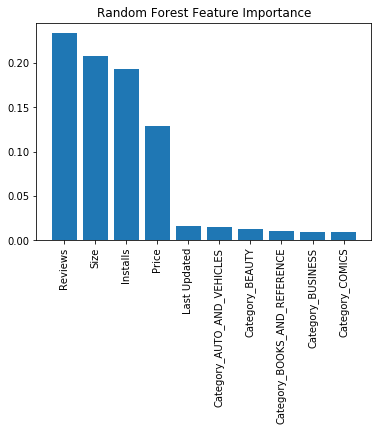

In [40]:
importances = rfc.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Create plot
plt.figure()

# Create plot title
plt.title("Random Forest Feature Importance")

# Add bars
plt.bar(range(10), importances[indices][:10])


# Add feature names as x-axis labels
plt.xticks(range(10), X.columns[:10], rotation=90)

# Show plot
plt.show()

As expected from weak correlations, the categories and content rating variables have little influence. In anticipation of slow run-time for the neural network model, let's only work with the top five features.

In [41]:
# New dataframe with reduced feature set. We retain the original dataframe as well.
df2 = df[['Rating', 'Reviews', 'Size', 'Installs','Price', 'Last Updated']]
df2

,Rating,Reviews,Size,Installs,Price,Last Updated
0,4,5.069,19000000.000,9.210,0.000,2788
1,4,6.874,14000000.000,13.122,0.000,2796
2,5,11.380,8700000.000,15.425,0.000,2994
3,4,12.281,25000000.000,17.728,0.000,2940
4,4,6.874,2800000.000,11.513,0.000,2952
...,...,...,...,...,...,...
10833,5,3.784,619000.000,6.908,0.000,1402
10834,4,1.946,2600000.000,6.215,0.000,2585
10836,4,3.638,53000000.000,8.517,0.000,2622
10837,5,1.386,3600000.000,4.605,0.000,2968


How does random forest perform with the reduced feature set?

In [42]:
X = df2.drop(columns = 'Rating', axis=1)
Y = df2['Rating']

In [43]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [44]:
rfc = ensemble.RandomForestClassifier()
%timeit rfc.fit(X_std,Y)

88.9 ms ± 848 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
score = cross_val_score(rfc, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.71021992 0.72703752 0.72056921 0.71668823 0.69857697 0.69340233
 0.67746114 0.69041451 0.69520104 0.68571429]
Accuracy: 0.702 (+/- 0.031)


It performs with almost the same accuracy! Eliminating the other features was probably a good choice. Now to MLP neural networks.

In [46]:
from sklearn.neural_network import MLPClassifier

In [47]:
# MLP with default parameters: 1 layer with 100 neurons.
mlp = MLPClassifier()
%timeit mlp.fit(X_std, Y)

5.15 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.71410091 0.69987063 0.70892626 0.70633894 0.72962484 0.72962484
 0.7357513  0.73445596 0.73670558 0.72467532]
Accuracy: 0.722 (+/- 0.026)


In [49]:
# MLP: 1 layer with 1000 neurons
mlp = MLPClassifier(hidden_layer_sizes=(1000))
%timeit mlp.fit(X_std, Y)

37.4 s ± 12.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.71151358 0.69987063 0.70245796 0.71668823 0.72703752 0.73479948
 0.73056995 0.74740933 0.74448768 0.73116883]
Accuracy: 0.725 (+/- 0.031)


In [51]:
# MLP: 3 layers with 10 neurons each
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10))
%timeit mlp.fit(X_std, Y)

4.53 s ± 737 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.71021992 0.69857697 0.71927555 0.7076326  0.72574386 0.7373868
 0.73704663 0.74611399 0.73540856 0.72467532]
Accuracy: 0.724 (+/- 0.029)


In [55]:
# MLP: layers 100,50,25
mlp = MLPClassifier(hidden_layer_sizes=(100,50,25))
%timeit mlp.fit(X_std, Y)

9.56 s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.70633894 0.69987063 0.71021992 0.70633894 0.72574386 0.72574386
 0.72927461 0.74481865 0.73929961 0.72337662]
Accuracy: 0.721 (+/- 0.028)


Accuracy doesn't seem to vary widely with altering the number of layers and neurons.

In [56]:
# MLP: logistic activation with default layers and neurons
mlp = MLPClassifier(activation='logistic')
%timeit mlp.fit(X_std, Y)

5.04 s ± 776 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.71798189 0.70116429 0.71539457 0.71151358 0.72445019 0.74902975
 0.71502591 0.73316062 0.74189364 0.73636364]
Accuracy: 0.725 (+/- 0.029)


In [58]:
# MLP: alpha one order of magnitude larger than default
mlp = MLPClassifier(alpha=0.001)
%timeit mlp.fit(X_std, Y)

4.97 s ± 870 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.7076326  0.69857697 0.71280724 0.70504528 0.72833118 0.73221216
 0.7357513  0.73963731 0.74448768 0.72987013]
Accuracy: 0.723 (+/- 0.030)


Let's try the larger feature set.

In [60]:
X = df.drop(columns = 'Rating', axis=1)
Y = df['Rating']

In [61]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [62]:
# MLP default
mlp = MLPClassifier()
%timeit mlp.fit(X_std, Y)

7.44 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
score = cross_val_score(mlp, X_std, Y, cv=10)
print(score)
print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std()*2))

[0.52134541 0.6545925  0.66364812 0.65717982 0.71668823 0.71280724
 0.68782383 0.69170984 0.70946822 0.70909091]
Accuracy: 0.672 (+/- 0.110)


The MLP network performs worse using the full features.

Closing Statements:

With only between 7000 and 8000 entries in the data left after cleaning, run time wasn't too much of an issue even for larger networks (even with the full feature set), so in this situation the MLP neural network model is the better choice when compared to random forest since the accuracy is higher.